In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,7)

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

# загрузка данных

In [5]:
train = pd.read_csv('data/train.csv')
players = pd.read_csv('data/players_feats.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.head()

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


In [7]:
players.head()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,...,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,...,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,...,22,26,19,1.37,1.10,88.5,20.5,6665,Dust2,583
3,5794,449,53.5,427,1.05,86.7,13.1,23,618,0.73,...,104,62,49,1.27,1.10,79.0,17.4,7532,Dust2,583
4,7998,173,32.9,130,1.33,82.4,2.9,9,225,0.77,...,19,27,25,1.08,1.08,81.5,16.2,4608,Dust2,439


In [8]:
test.head()

,index,map_id,team1_id,team2_id,map_name
0,713,309,5973,5752,Dust2
1,714,541,5973,5752,Vertigo
2,715,1,8297,7020,Nuke
3,716,392,8297,7020,Mirage
4,717,684,8297,7020,Overpass


# преобразование

## train

In [9]:
def train_full(train):
    '''
    функция преобразования трейна от вида "команда1, команда2,карта,победитель" к виду
    "команда, противник, карта, флаг победы"
    таким образом, для каждой игры будет 2 строки - относительно команды1 и команды2
    !важно: в исходном виде значение "кто выиграл" по сути является флагом победы команды2,
    а в новом - флаг победы команды1
    '''
    train1 = train.copy()
    train1.columns = ['map_id','team','2nd_team','map_name','win']
    train1['win'] = train1['win'].map({0:1,1:0})
    train2 = train.copy()
    train2.columns = ['map_id','2nd_team','team','map_name','win']
    return pd.concat([train1,train2])

In [10]:
train_full(train).sort_values('map_id').head(6)

,map_id,team,2nd_team,map_name,win
78,0,4869,11251,Vertigo,1
78,0,11251,4869,Vertigo,0
173,2,4869,5752,Ancient,0
173,2,5752,4869,Ancient,1
294,3,11595,10567,Dust2,1
294,3,10567,11595,Dust2,0


## players

In [11]:
def split_row(map_team_players):
    '''
    функция преобразует строку вида "p1*,p2*,p3*,p4*,p5*,team_id,map_id" к виду
    "p1*,team_id,map_id
    p2*,team_id,map_id
    ...
    p5*,team_id,map_id"
    '''
    column_names = ['p1_id',
                    'p1_total_kills',
                    'p1_headshots',
                    'p1_total_deaths',
                    'p1_kd_ratio',
                    'p1_damage_per_round',
                    'p1_grenade_damage_per_round',
                    'p1_maps_played',
                    'p1_rounds_played',
                    'p1_kills_per_round',
                    'p1_assists_per_round',
                    'p1_deaths_per_round',
                    'p1_saved_by_teammate_per_round',
                    'p1_saved_teammates_per_round',
                    'p1_rating',
                    'p1_kill_death',
                    'p1_kill_round',
                    'p1_rounds_with_kills',
                    'p1_kill_death_difference',
                    'p1_total_opening_kills',
                    'p1_total_opening_deaths',
                    'p1_opening_kill_ratio',
                    'p1_opening_kill_rating',
                    'p1_team_win_percent_after_first_kill',
                    'p1_first_kill_in_won_rounds']
    map_team_players_df = pd.DataFrame()
    for p_num in range(1, 6):
        p_columns = [i.replace('1', str(p_num)) for i in column_names]
        p_series = map_team_players[p_columns]
        p_series.index = [c[3:] for c in p_series.index]
        map_team_players_df = pd.concat([map_team_players_df, p_series.T], axis=1)

    map_team_players_df = map_team_players_df.T
    map_team_players_df['team_id'] = map_team_players['team_id']
    map_team_players_df['map_name'] = map_team_players['map_name']
    map_team_players_df['map_id'] = map_team_players['map_id']
    return map_team_players_df.reset_index(drop=True)

In [12]:
# преобразование players к новому виду функцией split_row
all_players = pd.DataFrame()
for m in range(len(players)):
    all_players = pd.concat([all_players, split_row(players.iloc[m, :])])
all_players = all_players.drop('map_name',axis=1)

In [13]:
# кол-во пропусков по столбцам
all_players.isna().sum()

id                                    0
total_kills                           0
headshots                             0
total_deaths                          0
kd_ratio                              0
damage_per_round                      0
grenade_damage_per_round              0
maps_played                           0
rounds_played                         0
kills_per_round                       0
assists_per_round                     0
deaths_per_round                      0
saved_by_teammate_per_round           0
saved_teammates_per_round             0
rating                                0
kill_death                            0
kill_round                            0
rounds_with_kills                     0
kill_death_difference                 0
total_opening_kills                   0
total_opening_deaths                  0
opening_kill_ratio                    0
opening_kill_rating                   0
team_win_percent_after_first_kill    18
first_kill_in_won_rounds              0


In [14]:
# добавление нового признака: среднее кол-во раундов за игру
all_players['mean_rounds_in_map'] = all_players['rounds_played']/all_players['maps_played']
# заполнение пропусков
all_players = all_players.fillna(0)

In [15]:
all_players.head()

,id,total_kills,headshots,total_deaths,kd_ratio,damage_per_round,grenade_damage_per_round,maps_played,rounds_played,kills_per_round,...,kill_death_difference,total_opening_kills,total_opening_deaths,opening_kill_ratio,opening_kill_rating,team_win_percent_after_first_kill,first_kill_in_won_rounds,team_id,map_id,mean_rounds_in_map
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,...,-22,10,13,0.77,0.85,60.0,8.2,6665,635,26.000000
1,7412,106,35.8,119,0.89,66.8,5.6,7,181,0.59,...,-13,17,27,0.63,0.89,82.4,15.4,6665,635,25.857143
2,9078,46,65.2,54,0.85,76.9,4.5,3,75,0.61,...,-8,4,14,0.29,0.62,50.0,5.0,6665,635,25.000000
3,13843,110,40.9,139,0.79,53.8,3.0,8,204,0.54,...,-29,15,20,0.75,0.87,53.3,8.2,6665,635,25.500000
4,15165,140,40.7,133,1.05,83.9,9.2,8,198,0.71,...,5,25,12,2.08,1.28,84.0,25.0,6665,635,24.750000


In [16]:
# среденее значение параметров команды для каждого матча
# здесь не учитываются параметры игроков, которые играют первый матч за полгода, так как у них нет статистики
all_players_mean = all_players[all_players['rounds_played'] > 0].groupby(['team_id', 'map_id'], as_index=False).mean()

In [17]:
all_players_mean.columns

Index(['team_id', 'map_id', 'id', 'total_kills', 'headshots', 'total_deaths',
       'kd_ratio', 'damage_per_round', 'grenade_damage_per_round',
       'maps_played', 'rounds_played', 'kills_per_round', 'assists_per_round',
       'deaths_per_round', 'saved_by_teammate_per_round',
       'saved_teammates_per_round', 'rating', 'kill_death', 'kill_round',
       'rounds_with_kills', 'kill_death_difference', 'total_opening_kills',
       'total_opening_deaths', 'opening_kill_ratio', 'opening_kill_rating',
       'team_win_percent_after_first_kill', 'first_kill_in_won_rounds',
       'mean_rounds_in_map'],
      dtype='object')

In [18]:
all_players[all_players['id'] == 4954].sort_values('maps_played')[['total_kills','total_deaths','maps_played','map_id']]

,total_kills,total_deaths,maps_played,map_id
0,67,89,4,434
0,79,92,5,284
0,76,111,5,152
0,91,104,5,646
0,93,130,6,49
...,...,...,...,...
0,315,363,21,45
0,333,332,21,246
0,334,358,21,123
0,346,396,22,678


На примере выше видно, что map_id не привязан ко времени, поэтому в данной задаче невозможно точно сортировать игры по времени.   
Так как статистика берется окном за полгода до игры, то неизвестно, происходит увелечение кол-ва матчей или уменьшение за счет их выхода из окна в полгода


# модель

## список фичей

In [19]:
team_features = ['n_games', 'winrate', 'n_games_2nd_team', 'winrate_2nd_team']

#map_features = ['map_winrate','map_count','map_winrate_2nd_team','map_count_2nd_team']
map_features = []

team1_player_features = ['headshots',
                         'kd_ratio',
                         'damage_per_round',
                         'grenade_damage_per_round',
                         'maps_played',
                         'assists_per_round',
                         #'deaths_per_round',
                         'rating',
                         'rounds_with_kills',
                         'kill_death_difference',
                         #'opening_kill_ratio',
                         'opening_kill_rating',
                         #'team_win_percent_after_first_kill',
                         'first_kill_in_won_rounds',
                         'mean_rounds_in_map']
team2_player_features = [i + '_2nd_team' for i in team1_player_features]

features = team_features + team1_player_features + team2_player_features + map_features

target = 'win'

In [20]:
print(features)

['n_games', 'winrate', 'n_games_2nd_team', 'winrate_2nd_team', 'headshots', 'kd_ratio', 'damage_per_round', 'grenade_damage_per_round', 'maps_played', 'assists_per_round', 'rating', 'rounds_with_kills', 'kill_death_difference', 'opening_kill_rating', 'first_kill_in_won_rounds', 'mean_rounds_in_map', 'headshots_2nd_team', 'kd_ratio_2nd_team', 'damage_per_round_2nd_team', 'grenade_damage_per_round_2nd_team', 'maps_played_2nd_team', 'assists_per_round_2nd_team', 'rating_2nd_team', 'rounds_with_kills_2nd_team', 'kill_death_difference_2nd_team', 'opening_kill_rating_2nd_team', 'first_kill_in_won_rounds_2nd_team', 'mean_rounds_in_map_2nd_team']


## валидация

In [22]:
scores = []
scores_accuracy = []


# валидация модели по n блокам
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(train):
    ## трейн
    fold_train = train.loc[train_index]
    fold_train = train_full(fold_train)
    
    # количество игр и винрейт команд
    team_stat = fold_train.groupby('team')['win'].agg(['count','mean']).reset_index()
    team_stat.columns = ['team','n_games','winrate']
    
    # добавление количества игр и винрейта к трейну
    fold_train = fold_train.merge(team_stat,on='team')
    fold_train = fold_train.merge(team_stat,left_on='2nd_team',right_on='team',suffixes=('','_2nd_team'))
    
    # добавление агрегированной статистики по игрокам к трейну
    fold_train = fold_train.merge(all_players_mean,left_on=['map_id','team'],right_on=['map_id','team_id'])
    fold_train = fold_train.merge(all_players_mean,left_on=['map_id','2nd_team'],right_on=['map_id','team_id'],suffixes=('','_2nd_team')) 
    
    # статистика по картам 
    '''map_stat = fold_train.groupby(['team','map_name'])['win'].agg(['count','mean']).reset_index().rename({'mean':'map_winrate','count':'map_count'},axis=1)
    map_stat = map_stat[map_stat['map_count'] > 1]
    
    fold_train = fold_train.merge(map_stat,left_on=['map_name','team'],right_on=['map_name','team'],how='left')
    fold_train = fold_train.merge(map_stat,left_on=['map_name','2nd_team'],right_on=['map_name','team'],how='left',suffixes=('','_2nd_team')) 
    fold_train[['map_winrate','map_winrate_2nd_team']] = fold_train[['map_winrate','map_winrate_2nd_team']].fillna(0.5)
    fold_train[['map_count','map_count_2nd_team']] = fold_train[['map_count','map_count_2nd_team']].fillna(0)
    '''
    ## тест
    fold_test = train.loc[test_index]
    
    # добавление количества игр и винрейта к тесту
    fold_test = fold_test.merge(team_stat,left_on='team1_id',right_on='team')
    fold_test = fold_test.merge(team_stat,left_on='team2_id',right_on='team',suffixes=('','_2nd_team'))
    
    # добавление агрегированной статистики по игрокам к тесту
    fold_test = fold_test.merge(all_players_mean,left_on=['map_id','team1_id'],right_on=['map_id','team_id'])
    fold_test = fold_test.merge(all_players_mean,left_on=['map_id','team2_id'],right_on=['map_id','team_id'],suffixes=('','_2nd_team')) 
    
    # статистика по картам 
    '''fold_test = fold_test.merge(map_stat,left_on=['map_name','team1_id'],right_on=['map_name','team'],how='left')
    fold_test = fold_test.merge(map_stat,left_on=['map_name','team2_id'],right_on=['map_name','team'],how='left',suffixes=('','_2nd_team')) 
    fold_test[['map_winrate','map_winrate_2nd_team']] = fold_test[['map_winrate','map_winrate_2nd_team']].fillna(0.5)
    fold_test[['map_count','map_count_2nd_team']] = fold_test[['map_count','map_count_2nd_team']].fillna(0)
    '''
    
    #fold_train = fold_train.sample(len(fold_train)).drop_duplicates('map_id')
    
    X_train = fold_train[features]
    y_train = fold_train[target]
    X_test = fold_test[features]
    y_test = fold_test['who_win']
    #scaler = StandardScaler().fit(X_train)
    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)
    
    # модель
    #clf = LogisticRegression(max_iter=100,random_state=0)
    clf = xgb.XGBClassifier(learning_rate = 0.1,
                            n_estimators=500,
                            max_depth=2,
                            min_child_weight=1,
                            #gamma=0,
                            #subsample=0.9,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic',
                            nthread=4,
                            #scale_pos_weight=1,
                            seed=0)
    #clf = RandomForestClassifier(n_estimators=250,max_depth=2,min_samples_leaf=1)
    
    clf.fit(X_train, y_train)
    
    # берем вероятность класса 0, т.к. модель предсказывает победу первой команды, а целевая переменная - второй
    pred = clf.predict_proba(X_test)[:,0]
    scores.append(roc_auc_score(y_test, pred))
    
    pred_class = [0 if i < 0.5 else 1 for i in pred]
    scores_accuracy.append(accuracy_score(y_test, pred_class))
    

scores = pd.Series(scores)
print('ROC-AUC')
print(scores.mean())
print(len(scores[scores<=0.5]),'bad folds')
print(scores)

scores_accuracy = pd.Series(scores_accuracy)
print('ACCURACY')
print(scores_accuracy.mean())
print(scores_accuracy)

ROC-AUC
0.6455709559890916
0 bad folds
0    0.678039
1    0.659861
2    0.665277
3    0.537662
4    0.687015
dtype: float64
ACCURACY
0.6178128534136926
0    0.622378
1    0.652482
2    0.640845
3    0.556338
4    0.617021
dtype: float64


Модель показывет точность на уровне MVP datalouna, согласно статье на VC :)

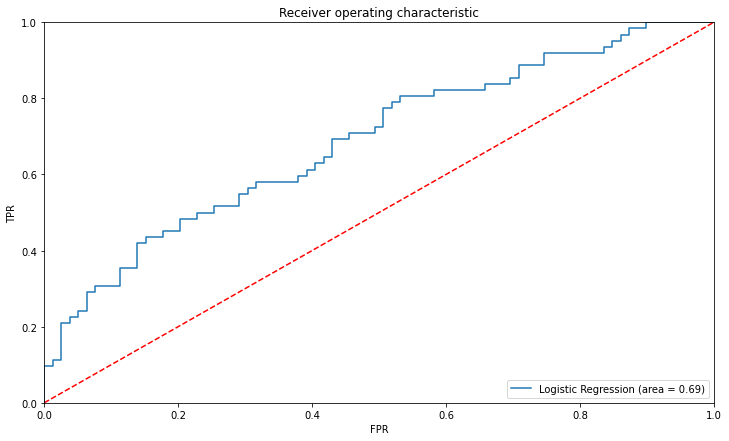

In [19]:
# график рок-аук последней итерации валидации
logit_roc_auc = roc_auc_score(fold_test['who_win'], pred)
fpr, tpr, thresholds = roc_curve(fold_test['who_win'], pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

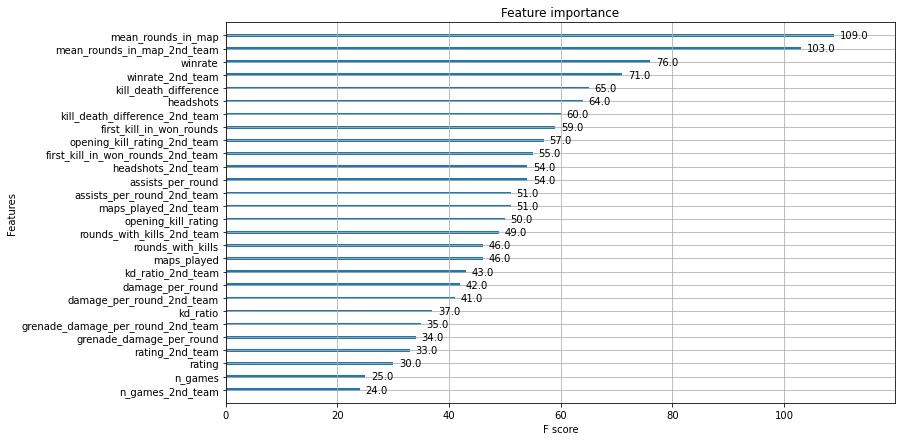

In [20]:
xgb.plot_importance(clf)

# прогноз теста

In [25]:
final_train = train.copy()
final_test = test.copy()


## треин
final_train = train_full(final_train)
# количество игр и винрейт команд
team_stat = final_train.groupby('team')['win'].agg(['count','mean']).reset_index()
team_stat.columns = ['team','n_games','winrate']

# добавление количества игр и винрейта к трейну
final_train = final_train.merge(team_stat,on='team')
final_train = final_train.merge(team_stat,left_on='2nd_team',right_on='team',suffixes=('','_2nd_team'))

# добавление агрегированной статистики по игрокам к трейну
final_train = final_train.merge(all_players_mean,left_on=['map_id','team'],right_on=['map_id','team_id'])
final_train = final_train.merge(all_players_mean,left_on=['map_id','2nd_team'],right_on=['map_id','team_id'],suffixes=('','_2nd_team')) 

## тест

# добавление количества игр и винрейта к тесту
final_test = final_test.merge(team_stat,left_on='team1_id',right_on='team')
final_test = final_test.merge(team_stat,left_on='team2_id',right_on='team',suffixes=('','_2nd_team'))

# добавление агрегированной статистики по игрокам к тесту
final_test = final_test.merge(all_players_mean,left_on=['map_id','team1_id'],right_on=['map_id','team_id'])
final_test = final_test.merge(all_players_mean,left_on=['map_id','team2_id'],right_on=['map_id','team_id'],suffixes=('','_2nd_team')) 

X_train = final_train[features]
y_train = final_train[target]
X_test = final_test[features]

## вариант 1 (логрег)

In [26]:
# модель
clf = LogisticRegression(max_iter=100,random_state=0)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
clf.fit(X_train, y_train)

# берем вероятность класса 0, т.к. модель предсказывает победу первой команды, а целевая переменная - второй
pred_1 = clf.predict_proba(X_test)[:,0]

In [27]:
pred_1

array([0.71853637, 0.6766068 , 0.62672708, 0.64334677, 0.64395153,
       0.45923748, 0.62139631, 0.63573876, 0.63925927, 0.56500867,
       0.56258389, 0.60442259, 0.61236871, 0.31261059, 0.31355299,
       0.19941551, 0.1454231 , 0.14614108, 0.17145935, 0.15570012,
       0.54315383, 0.53100659, 0.55618772, 0.48909133, 0.50177507,
       0.71241557, 0.71914275, 0.49620948, 0.56852219, 0.55120831])

In [28]:
pred_1_labels = [0 if i < 0.5 else 1 for i in pred_1]
print(pred_1_labels)

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


In [29]:
result_1 = test.copy()
result_1['pred'] = pred_1
result_1

,index,map_id,team1_id,team2_id,map_name,pred
0,713,309,5973,5752,Dust2,0.718536
1,714,541,5973,5752,Vertigo,0.676607
2,715,1,8297,7020,Nuke,0.626727
3,716,392,8297,7020,Mirage,0.643347
4,717,684,8297,7020,Overpass,0.643952
5,718,85,4494,4411,Vertigo,0.459237
6,719,314,4494,4411,Inferno,0.621396
7,720,403,4494,4411,Mirage,0.635739
8,721,125,4608,7718,Inferno,0.639259
9,722,241,4608,7718,Mirage,0.565009


In [30]:
result_1.to_csv('result_1.csv')

## вариант 2 XGBoost

In [27]:
# модель
clf = xgb.XGBClassifier(learning_rate = 0.1,
                            n_estimators=500,
                            max_depth=2,
                            min_child_weight=1,
                            #gamma=0,
                            #subsample=0.9,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic',
                            nthread=4,
                            #scale_pos_weight=1,
                            seed=0)
clf.fit(X_train, y_train)

# берем вероятность класса 0, т.к. модель предсказывает победу первой команды, а целевая переменная - второй
pred_2 = clf.predict_proba(X_test)[:,0]

In [28]:
pred_2

array([0.83607054, 0.81990844, 0.46353036, 0.61696935, 0.5973681 ,
       0.45664567, 0.5346223 , 0.514973  , 0.5273124 , 0.5775412 ,
       0.3997078 , 0.688675  , 0.74296063, 0.30449808, 0.3963961 ,
       0.3520521 , 0.13822532, 0.18360466, 0.16388625, 0.30093896,
       0.4592132 , 0.31678843, 0.44469488, 0.5879208 , 0.51119703,
       0.8250213 , 0.8526827 , 0.77535915, 0.69450665, 0.5920962 ],
      dtype=float32)

In [29]:
pred_2_labels = [0 if i < 0.5 else 1 for i in pred_2]
print(pred_2_labels)

[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


In [30]:
result_2 = test.copy()
result_2['pred'] = pred_2
result_2

,index,map_id,team1_id,team2_id,map_name,pred
0,713,309,5973,5752,Dust2,0.836071
1,714,541,5973,5752,Vertigo,0.819908
2,715,1,8297,7020,Nuke,0.463530
3,716,392,8297,7020,Mirage,0.616969
4,717,684,8297,7020,Overpass,0.597368
5,718,85,4494,4411,Vertigo,0.456646
6,719,314,4494,4411,Inferno,0.534622
7,720,403,4494,4411,Mirage,0.514973
8,721,125,4608,7718,Inferno,0.527312
9,722,241,4608,7718,Mirage,0.577541


In [31]:
result_2.to_csv('result_2.csv')

## вариант 3 случайный лес

In [32]:
# модель
clf = RandomForestClassifier(n_estimators=250,max_depth=2,min_samples_leaf=1)
clf.fit(X_train, y_train)

# берем вероятность класса 0, т.к. модель предсказывает победу первой команды, а целевая переменная - второй
pred_3 = clf.predict_proba(X_test)[:,0]

In [33]:
pred_3

array([0.54199249, 0.53827644, 0.52534429, 0.53007109, 0.51695112,
       0.46646045, 0.50227932, 0.49528834, 0.50522208, 0.49633724,
       0.49420287, 0.51083185, 0.50331848, 0.49401587, 0.48995262,
       0.4360929 , 0.43617888, 0.43019593, 0.43503686, 0.43522958,
       0.50056227, 0.50210933, 0.50657536, 0.50109308, 0.50865202,
       0.51991583, 0.5232555 , 0.52624672, 0.51854073, 0.5216518 ])

In [34]:
pred_3_labels = [0 if i < 0.5 else 1 for i in pred_3]
print(pred_3_labels)

[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [35]:
result_3 = test.copy()
result_3['pred'] = pred_3
result_3

,index,map_id,team1_id,team2_id,map_name,pred
0,713,309,5973,5752,Dust2,0.541992
1,714,541,5973,5752,Vertigo,0.538276
2,715,1,8297,7020,Nuke,0.525344
3,716,392,8297,7020,Mirage,0.530071
4,717,684,8297,7020,Overpass,0.516951
5,718,85,4494,4411,Vertigo,0.466460
6,719,314,4494,4411,Inferno,0.502279
7,720,403,4494,4411,Mirage,0.495288
8,721,125,4608,7718,Inferno,0.505222
9,722,241,4608,7718,Mirage,0.496337


In [36]:
result_3.to_csv('result_3.csv')

# сравнение результатов

<AxesSubplot:>

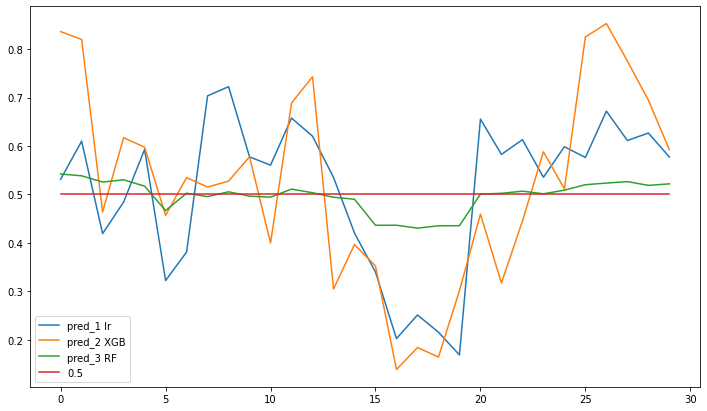

In [37]:
all_results = pd.DataFrame({'pred_1 lr':pred_1,'pred_2 XGB':pred_2,'pred_3 RF':pred_3})
all_results['0.5'] = 0.5
all_results.plot()

In [38]:
all_results_labels = pd.DataFrame({'pred_1 lr':pred_1_labels,'pred_2 XGB':pred_2_labels,'pred_3 RF':pred_3_labels})
all_results_labels['sum'] = all_results_labels.sum(axis=1)
all_results_labels['sum'].value_counts()

3    13
2     7
0     7
1     3
Name: sum, dtype: int64

# Вывод

Была построена модель с качеством на валидации ROC-AUC 0.65 и ACCURACY 0.62.  
В качестве входных параментров были использованы значения % побед и кол-ва игр команд в обучающей выборке, а также средние значения игроков за период полгода до матча.  
Учитывать карту, на которой проходил матч, не удалось, так как недостаточно данных для расчета результатов команд на каждой карте.   
Для улучшения прогноза можно учитывать не только средние значения по параметрам игроков команды, но и другие агрегации/факторы, например их разброс. Также, возможно, на точность прогноза повлиял бы фактор наличия в команде топ игроков.  
Дополнительно, при наличии временных меток, можно было бы задавать больший вес статистике по играм, прошедшим недавно


In [39]:
# винрейт команд на картах (при сыгранных >=2 играх на карте)
map_stat = train_full(train).groupby(['team','map_name'])['win'].agg(['count','mean']).reset_index().rename({'mean':'map_winrate','count':'map_count'},axis=1)
map_stat = map_stat[map_stat['map_count'] > 1]
pivot_map_stat = map_stat.pivot_table(columns='map_name',index='team',values='map_winrate')
with pd.option_context('display.max_rows', 100):
    print(pivot_map_stat)

map_name   Ancient     Dust2   Inferno    Mirage      Nuke  Overpass   Vertigo
team                                                                          
4411      0.615385       NaN  0.666667  0.285714  0.400000  0.600000  0.444444
4494      0.714286       NaN  0.400000  0.375000  0.600000  0.666667  0.500000
4608      0.833333  0.833333  0.545455  0.666667  0.700000  0.666667       NaN
4773      0.000000  0.750000  0.500000  0.333333  0.500000  0.666667  0.666667
4863           NaN       NaN       NaN       NaN       NaN  0.333333       NaN
4869      0.461538  0.500000       NaN  0.526316  0.705882  0.250000  0.857143
4991      0.500000       NaN  0.800000  0.333333  0.500000  0.400000       NaN
5005      0.000000  0.000000  0.200000       NaN  0.333333  0.400000  0.000000
5378      0.500000       NaN       NaN  0.000000       NaN       NaN  0.333333
5422           NaN       NaN  0.500000       NaN       NaN       NaN  0.333333
5752      1.000000  0.600000  0.400000  0.625000    

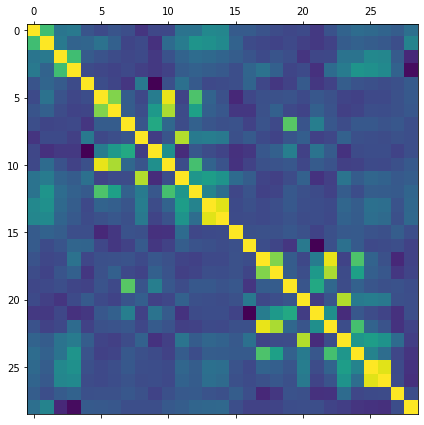

In [40]:
# корреляция признаков
plt.matshow(fold_train[features+[target]].corr())
plt.show()

In [41]:
fold_train[features+[target]].corr()

,n_games,winrate,n_games_2nd_team,winrate_2nd_team,headshots,kd_ratio,damage_per_round,grenade_damage_per_round,maps_played,assists_per_round,...,grenade_damage_per_round_2nd_team,maps_played_2nd_team,assists_per_round_2nd_team,rating_2nd_team,rounds_with_kills_2nd_team,kill_death_difference_2nd_team,opening_kill_rating_2nd_team,first_kill_in_won_rounds_2nd_team,mean_rounds_in_map_2nd_team,win
n_games,1.000000,0.597292,0.197197,0.215378,0.026861,-0.020508,0.027506,0.001497,-0.114227,-0.035886,...,-0.036220,-0.021446,-0.096546,0.013709,0.104684,0.150451,0.132740,0.110374,0.070222,0.165746
winrate,0.597292,1.000000,0.215378,0.104209,0.111258,0.180307,0.090304,-0.037934,-0.021770,-0.128459,...,-0.024070,-0.065083,-0.096292,-0.054996,0.069933,0.094079,0.073983,0.053949,0.000522,0.273092
n_games_2nd_team,0.197197,0.215378,1.000000,0.597292,0.064976,0.023234,-0.010065,-0.036220,-0.021446,-0.096546,...,0.001497,-0.114227,-0.035886,-0.032227,0.186137,0.183318,0.296190,0.288166,0.061690,-0.165746
winrate_2nd_team,0.215378,0.104209,0.597292,1.000000,-0.013972,-0.032663,-0.049808,-0.024070,-0.065083,-0.096292,...,-0.037934,-0.021770,-0.128459,0.146324,0.234142,0.364454,0.347167,0.307982,0.097550,-0.273092
headshots,0.026861,0.111258,0.064976,-0.013972,1.000000,-0.003523,-0.039308,-0.106482,0.215189,-0.315162,...,-0.054118,0.058046,-0.099580,-0.054676,0.072910,0.021953,0.004327,-0.007629,0.008047,0.056115
kd_ratio,-0.020508,0.180307,0.023234,-0.032663,-0.003523,1.000000,0.749008,0.065164,-0.030531,0.238822,...,0.022628,-0.020514,0.041502,0.013377,-0.044343,-0.059544,-0.024306,-0.027322,0.008586,0.053738
damage_per_round,0.027506,0.090304,-0.010065,-0.049808,-0.039308,0.749008,1.000000,0.069803,0.001511,0.397622,...,-0.025486,-0.050591,0.089449,0.021810,-0.067965,-0.047633,-0.000798,-0.003989,0.008537,0.043105
grenade_damage_per_round,0.001497,-0.037934,-0.036220,-0.024070,-0.106482,0.065164,0.069803,1.000000,0.033269,0.478540,...,0.659852,0.028801,0.247133,0.044409,-0.009212,0.044567,0.045456,0.020749,0.043868,0.001869
maps_played,-0.114227,-0.021770,-0.021446,-0.065083,0.215189,-0.030531,0.001511,0.033269,1.000000,-0.076619,...,0.028801,0.075585,-0.061141,-0.033413,0.092719,0.005369,-0.001291,-0.008733,0.009394,0.001634
assists_per_round,-0.035886,-0.128459,-0.096546,-0.096292,-0.315162,0.238822,0.397622,0.478540,-0.076619,1.000000,...,0.247133,-0.061141,0.188090,0.061762,-0.125036,-0.016648,-0.002790,-0.005192,-0.052785,-0.001270
